In [84]:
##Import Packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from supervised.automl import AutoML 
from tpot import TPOTClassifier

In [99]:
##Read Data
df =  pd.read_csv("../Data/breast-cancer.data", header = None)

##Show Top 5 Rows
df.head()

,0,1,2,3,4,5,6,7,8,9
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [100]:
##Check Missing Values and Object Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       286 non-null    object
 1   1       286 non-null    object
 2   2       286 non-null    object
 3   3       286 non-null    object
 4   4       286 non-null    object
 5   5       286 non-null    object
 6   6       286 non-null    int64 
 7   7       286 non-null    object
 8   8       286 non-null    object
 9   9       286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [101]:
##Clean & Prep Data (Variable descriptions can be found in breast-cancer.names)

###Rename Coloumns
df = df.rename(columns = {0:'cancerClass', 1:'age', 2:'menopause', 3:'tumor-size', 4:'inv-nodes', 
                     5:'node-caps', 6:'deg-malig', 7:'breast', 8:'breast-quad', 9:'irradiat'})
###Rename element levels
df.cancerClass = df.cancerClass.map({'no-recurrence-events':'0', 'recurrence-events':'1'})

In [102]:
##Generate Descriptive Statistics
include = ['object', 'int']
df.describe(include = include)

,cancerClass,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
count,286,286,286,286,286,286,286.000000,286,286,286
unique,2,6,3,11,7,3,NaN,2,6,2
top,0,50-59,premeno,30-34,0-2,no,NaN,left,left_low,no
freq,201,96,150,60,213,222,NaN,152,110,218
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.048951,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,0.738217,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN


In [76]:
def df2DescPlot(df):
    """if a column is an object, create a barplot"""
    
    fig_width = int(np.ceil(np.sqrt(len(df.columns))))
    fig, axs = plt.subplots(fig_width, fig_width, figsize=(20,20))
    
    for idx, col in enumerate(df.columns):
        x = idx
        x, y = divmod(idx, fig_width)
        if df[col].dtype == 'object':
            df[col].value_counts().plot(kind='bar', ax=axs[x][y], title=col, rot=0)

        else:
            df[col].plot(kind='density', ax = axs[x][y], title = col)

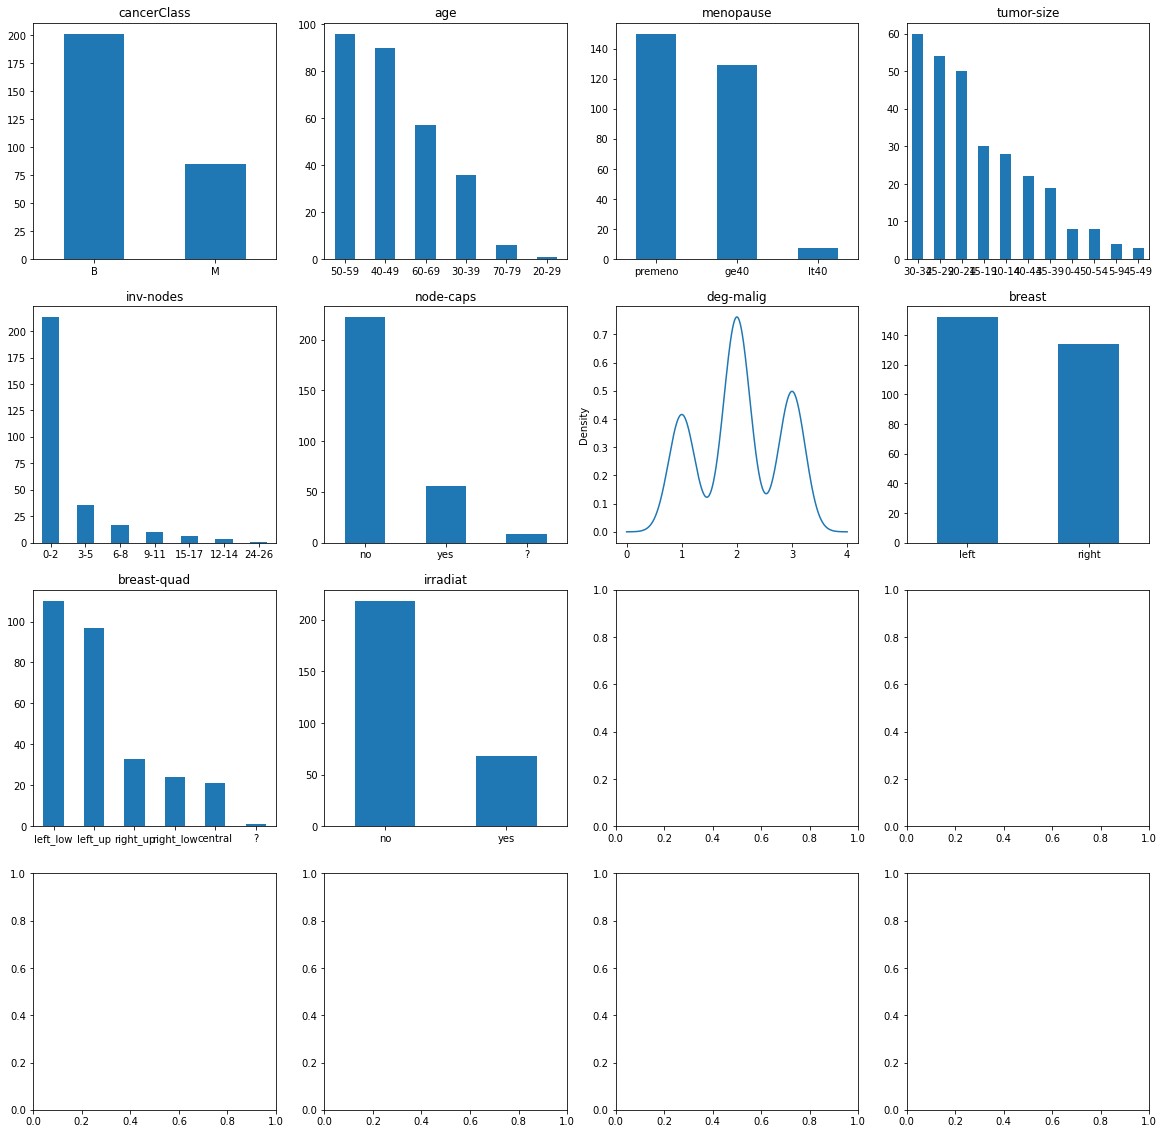

In [7]:
df2DescPlot(df)

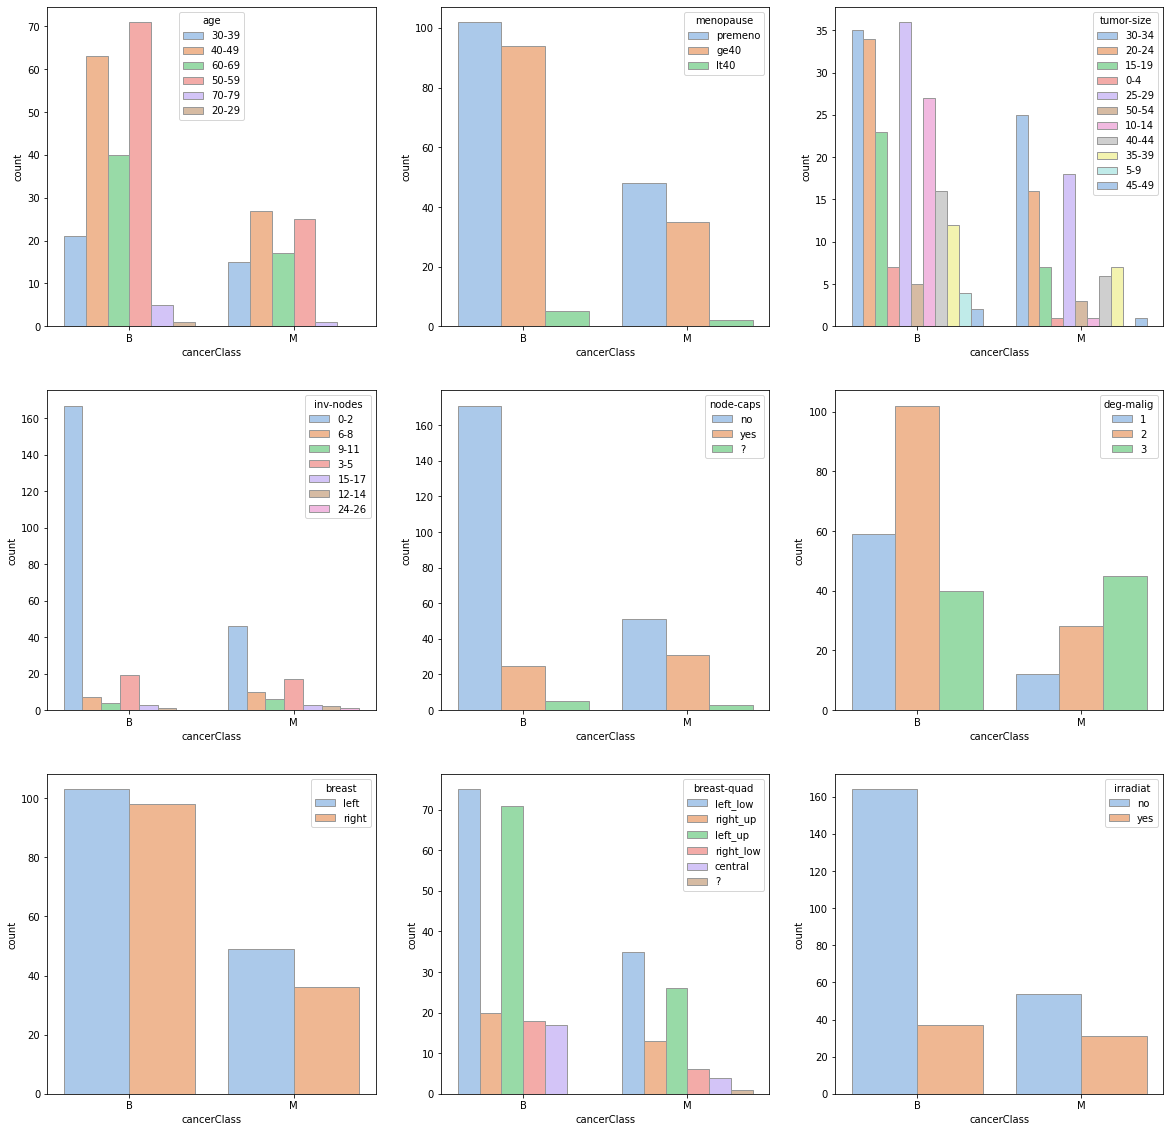

In [88]:
fig, axs = plt.subplots(3, 3, figsize=(20,20))
k = 0
for i in df.columns.to_list()[1:]:
    x, y = divmod(k,3)
    sns.countplot(x="cancerClass", hue=i, 
            palette="pastel", edgecolor=".6",
            data=df, ax=axs[x][y])
    k += 1


In [103]:
#Remove Rows from a Categorical Variable whose Value Counts were Small
for i in df.columns.to_list():
    counts = df[i].value_counts()
    rmCategory = counts.index[counts <= 5].to_list()
    rmCounts = counts[counts <= 5].to_list()
    dfNew = df.loc[df[i].isin(counts.index[counts > 5])]

    if len(rmCategory) > 0: 
        for k in range(len(rmCategory)):
            print(f"The {rmCategory[k]} category in variable {i} only had {rmCounts[k]} count(s) and was thus removed.")
    

The 20-29 category in variable age only had 1 count(s) and was thus removed.
The 5-9 category in variable tumor-size only had 4 count(s) and was thus removed.
The 45-49 category in variable tumor-size only had 3 count(s) and was thus removed.
The 12-14 category in variable inv-nodes only had 3 count(s) and was thus removed.
The 24-26 category in variable inv-nodes only had 1 count(s) and was thus removed.
The ? category in variable breast-quad only had 1 count(s) and was thus removed.


In [104]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[0:,1:], df.iloc[0:,0], 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

#Select nymerical and categorical columns
numerical_cols = X_train.dtypes.index[X_train.dtypes == 'int'].to_list()
categorical_cols = X_train.dtypes.index[X_train.dtypes == 'object'].to_list()


In [11]:
numerical_cols

['deg-malig']

In [105]:
#Preprocess numerical data
numerical_transformer = SimpleImputer(strategy='constant')

#Preprocess categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

#Define the model
model = RandomForestClassifier(n_estimators=100, random_state=0)

#Bundle preprocessing and modeling code 
clf = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', model)
                              ]
              )



In [106]:
# Preprocessing of training data, fit model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)


print('Accuracy:', accuracy_score(y_valid, y_pred))

Accuracy: 0.7758620689655172


In [93]:
#Grid search best estimator numbers
accu = []
for i in range(1,1000, 50):
    model = RandomForestClassifier(n_estimators=i, random_state=0)
    clf = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', model)
                              ]
              )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    accuScore =  accuracy_score(y_valid, y_pred)
    accu.append(accuScore)
    print('Accuracy (n_estimator =', i,'):', accuScore)



Accuracy (n_estimator = 1 ): 0.7068965517241379
Accuracy (n_estimator = 51 ): 0.7241379310344828
Accuracy (n_estimator = 101 ): 0.7758620689655172
Accuracy (n_estimator = 151 ): 0.7586206896551724
Accuracy (n_estimator = 201 ): 0.7758620689655172
Accuracy (n_estimator = 251 ): 0.7586206896551724
Accuracy (n_estimator = 301 ): 0.7586206896551724
Accuracy (n_estimator = 351 ): 0.7413793103448276
Accuracy (n_estimator = 401 ): 0.7586206896551724
Accuracy (n_estimator = 451 ): 0.7413793103448276
Accuracy (n_estimator = 501 ): 0.7586206896551724
Accuracy (n_estimator = 551 ): 0.7586206896551724
Accuracy (n_estimator = 601 ): 0.7413793103448276
Accuracy (n_estimator = 651 ): 0.7413793103448276
Accuracy (n_estimator = 701 ): 0.7413793103448276
Accuracy (n_estimator = 751 ): 0.7413793103448276
Accuracy (n_estimator = 801 ): 0.7413793103448276
Accuracy (n_estimator = 851 ): 0.7413793103448276
Accuracy (n_estimator = 901 ): 0.7413793103448276
Accuracy (n_estimator = 951 ): 0.7586206896551724


In [94]:
for i in [x for x,y in enumerate(accu) if y == max(accu)]:
    print('Best model performance happened at n_estimator = ', range(1,1000, 50)[i], 
          'where accuracy rate = ', round(accu[i],3))

Best model performance happened at n_estimator =  101 where accuracy rate =  0.776
Best model performance happened at n_estimator =  201 where accuracy rate =  0.776


In [95]:
#Auto ML
automl = AutoML(mode='Perform')
automl.fit(X_train, y_train)
predictions = automl.predict(X_valid)

AutoML directory: AutoML_3
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Linear', 'Random Forest', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network']
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble']
* Step simple_algorithms will try to check up to 1 model
1_Linear logloss 0.573976 trained in 9.57 seconds (1-sample predict time 0.1013 seconds)
* Step default_algorithms will try to check up to 5 models
2_Default_LightGBM logloss 0.546221 trained in 2.99 seconds (1-sample predict time 0.0899 seconds)
3_Default_Xgboost logloss 0.558709 trained in 4.04 seconds (1-sample predict time 0.0795 seconds)
4_Default_CatBoost logloss 0.529719 trained in 4.7 seconds (1-sample predict time 0.0295 seconds)
5_Default_NeuralNetwork logloss 0.707808 trained in 2.15 seconds (1-sam

KeyboardInterrupt: 

In [ ]:
# compute the accuracy on test data
predictions = automl.predict_all(X_valid)
print(predictions.head())
print("Test accuracy:", accuracy_score(y_valid, predictions["label"].astype(str)))

In [ ]:
X_train_onehot = preprocessor.fit_transform(X_train).toarray()
X_valid_onehot = preprocessor.transform(X_valid).toarray()

In [108]:
y_train.astype('float')


46     0
257    1
214    1
167    0
223    1
      ..
251    1
192    0
117    0
47     0
172    0
Name: cancerClass, Length: 228, dtype: object

In [117]:
pipeline_optimizer = TPOTClassifier()
pipeline_optimizer = TPOTClassifier(generations=20, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

pipeline_optimizer.fit(X_train_onehot, y_train.astype('float'))



Generation 1 - Current best internal CV score: 0.7501449275362319

Generation 2 - Current best internal CV score: 0.7543961352657005

Generation 3 - Current best internal CV score: 0.7545893719806764

Generation 4 - Current best internal CV score: 0.758743961352657

Generation 5 - Current best internal CV score: 0.7676328502415458

Generation 6 - Current best internal CV score: 0.7676328502415458

Generation 7 - Current best internal CV score: 0.7676328502415458

Generation 8 - Current best internal CV score: 0.7676328502415458

Generation 9 - Current best internal CV score: 0.7676328502415458

Generation 10 - Current best internal CV score: 0.7676328502415458

Generation 11 - Current best internal CV score: 0.7676328502415458

Generation 12 - Current best internal CV score: 0.7676328502415458

Generation 13 - Current best internal CV score: 0.7676328502415458

Generation 14 - Current best internal CV score: 0.7676328502415458

Generation 15 - Current best internal CV score: 0.7676328

TPOTClassifier(generations=20, population_size=20, random_state=42, verbosity=2)

In [118]:
pipeline_optimizer.score(X_valid_onehot, y_valid.astype("float"))


0.6724137931034483